<a href="https://colab.research.google.com/github/Hanoada/Hanoada/blob/main/Meteor_Strike_Probability_Tool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cp /content/drive/MyDrive/main.py /content
!cp /content/drive/MyDrive/SMOTESampler.py /content
!cp /content/drive/MyDrive/DetermineSearch.py /content
!cp /content/drive/MyDrive/Meteorite_Landings_USA_latlongyear.csv /content
!pip install geopy
!pip install auto-py-to-exe

city name: Logan
state: UT
radius: 50
Epoch 1/100
14/14 [==============================] - 1s 23ms/step - loss: 30.2299 - accuracy: 0.5631 - binary_accuracy: 0.5412 - val_loss: 21.4433 - val_accuracy: 0.4555 - val_binary_accuracy: 0.5348
Epoch 2/100
14/14 [==============================] - 0s 6ms/step - loss: 12.5938 - accuracy: 0.5518 - binary_accuracy: 0.5370 - val_loss: 5.4157 - val_accuracy: 0.4555 - val_binary_accuracy: 0.5281
Epoch 3/100
14/14 [==============================] - 0s 5ms/step - loss: 3.5860 - accuracy: 0.4414 - binary_accuracy: 0.5152 - val_loss: 2.0760 - val_accuracy: 0.5340 - val_binary_accuracy: 0.5086
Epoch 4/100
14/14 [==============================] - 0s 5ms/step - loss: 2.4211 - accuracy: 0.4347 - binary_accuracy: 0.4986 - val_loss: 1.9866 - val_accuracy: 0.5340 - val_binary_accuracy: 0.4972
Epoch 5/100
14/14 [==============================] - 0s 6ms/step - loss: 2.7312 - accuracy: 0.4369 - binary_accuracy: 0.4922 - val_loss: 1.9104 - val_accuracy: 0.5340 - v

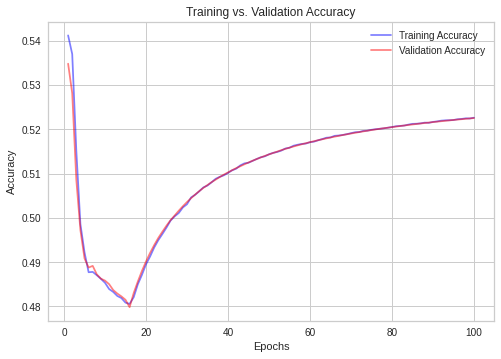

20/20 [==============================] - 0s 2ms/step - loss: 1.0970 - accuracy: 0.5307 - binary_accuracy: 0.5227


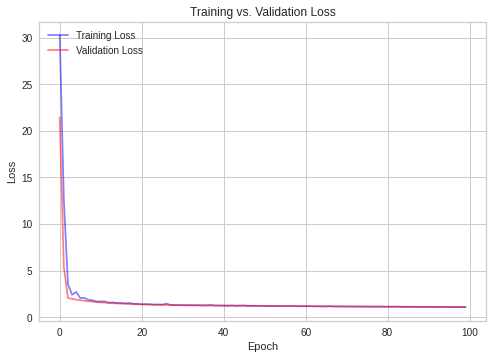

1/1 [==============================] - 0s 63ms/step


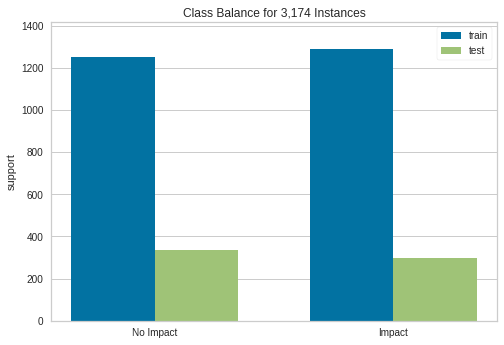

final_prediction: 4.234661273539038


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopy
from sklearn.model_selection import train_test_split
from yellowbrick import ClassBalance
from yellowbrick.features import ParallelCoordinates
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split
from yellowbrick import ClassBalance
from yellowbrick.features import ParallelCoordinates
from keras import regularizers
from tensorflow.python.keras.metrics import BinaryAccuracy
from geopy import geocoders as Nominatim
from DetermineSearch import determineSearch
from SMOTESampler import overSample


# This line of code gathers the meteorite data set from the local environment and assembles it into a pandas DataFrame
# called "meteor_data". This is the DataFrame used throughout the code.
meteor_data = pd.read_csv("/content/drive/MyDrive/Meteorite_Landings_USA_latlongyear.csv")

# The code below sets the PySimpleGUI theme colors and "layout1 = getGUI()" gets the layout for "window1" from the
# GetGUI.py file included with this program.

user_city = input("city name: ")
user_state = input("state: ")
target_radius = int(input("radius: "))


# This is how PySimpleGUI gets the city, state, and radius values from user input (as keys to the layout).
# user_city = values['-CITY-']
# user_state = values['-STATE-']
# target_radius = int(values['-RADIUS-'])

# Use GeoPy GeoCoders to get the latitude and longitude coordinates for the user-input city and state.
user_location = (user_city + ', ' + user_state)
my_nom = geopy.geocoders.Nominatim(user_agent="myGeocoder")
location = my_nom.geocode(user_location)

# Parameterize user input to use throughout program.
user_lat = location.latitude
user_lon = location.longitude
target_point = (user_lat, user_lon)

# Call the "determineSearch()" function in the "DetermineSearch.py" file included with this program.
meteor_data, target_point, target_radius2, true_rows = determineSearch(meteor_data, target_point, target_radius)

# Create a function to determine the number of years spanned by the meteors within the user's search criteria.
years_spanned = max(true_rows['year']) - min(true_rows['year'])

# Create a list of feature names to use when using / splitting data and training the Neural Network.
feature_names = ['latitude', 'longitude', 'year']

# Load the meteor_data data set into a Pandas DataFrame object.
X = meteor_data[feature_names]
y = meteor_data['in_target']

# Use "overSample()" function in the "SMOTESampler.py" file included with this program to balance the data
# by creating synthetic test cases.
X_resampled, y_resampled = overSample(true_rows, X, y)

# Split the data set into training, validation, and test sets.
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train_new, X_val, y_train_new, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2,
                                                                  random_state=42)

# Define the Neural Network architecture. I chose to include an input layer with 64 neurons, followed by a
# hidden layers of 8 neurons and an output layer of one neuron.
model = keras.Sequential([
    keras.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.05), input_shape=[3]),
    keras.layers.Dropout(0.01),
    keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    keras.layers.Dropout(0.01),
    keras.layers.Dense(4, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    keras.layers.Dense(1, activation='sigmoid')
])

        # Compile the model with binary cross-entropy loss and Adam optimizer. Binary cross-entropy calculates the
        # difference between the predicted output and true output and adjusts the model's biases to minimize the
        # difference. The "Adam()" optimizer is a stochastic gradient descent optimization algorithm used in training
        # deep neural networks. 0.001 is the learning rate, which determines the step size at which the optimizer
        # updates the parameters while training.
        # model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy', BinaryAccuracy()])

        # The test_input below is a NumPy array of the user-entered 'latitude' and 'longitude' as well as an entry for
        # each year from 2024 to 2074 (25 years).
test_input = np.array([([user_lat, user_lon, 2024], [user_lat, user_lon, 2025], [user_lat, user_lon, 2026],
                       [user_lat, user_lon, 2027], [user_lat, user_lon, 2028], [user_lat, user_lon, 2029],
                       [user_lat, user_lon, 2030], [user_lat, user_lon, 2031], [user_lat, user_lon, 2032],
                       [user_lat, user_lon, 2033], [user_lat, user_lon, 2034], [user_lat, user_lon, 2035],
                       [user_lat, user_lon, 2036], [user_lat, user_lon, 2037], [user_lat, user_lon, 2038],
                       [user_lat, user_lon, 2039], [user_lat, user_lon, 2040], [user_lat, user_lon, 2041],
                       [user_lat, user_lon, 2042], [user_lat, user_lon, 2043], [user_lat, user_lon, 2044],
                       [user_lat, user_lon, 2045], [user_lat, user_lon, 2046], [user_lat, user_lon, 2047],
                       [user_lat, user_lon, 2048])])
        # This line of code reshapes the data to fit the values above.
test_input = test_input.reshape((25, 3))

        # The history code trains the neural network model using the "fit" method in Keras. Epochs is the number of
        # times the model will iterate over the data set. 30% of the data is split for validation.
history = model.fit(X_test, y_test, epochs=100, validation_split=0.3, shuffle=True, verbose=1)

        # Get the binary accuracy of the model. Used in the final prediction calculation. The epochs variable needs to
        # be set as a range because the neural network may or may not actually iterate 100 times.
train_acc = history.history['binary_accuracy']
val_acc = history.history['val_binary_accuracy']
epochs = range(1, len(train_acc) + 1)

        # Plot the training and validation accuracy graph. The 'alpha' argument sets transparency level for the lines.
plt.plot(epochs, train_acc, '-', color='blue', label='Training Accuracy', alpha=0.5)
plt.plot(epochs, val_acc, '-', color='red', label='Validation Accuracy', alpha=0.5)
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

        # Evaluate the neural network on the test data.
test_results = model.evaluate(X_test, y_test)

        # Plot the training & validation loss values.
plt.plot(history.history['loss'], color='blue', alpha=0.5, label='Training Loss')
plt.plot(history.history['val_loss'], color='red', alpha=0.5, label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left')
plt.show()

        # Make predictions on new data. This is pulling the test_input from above, which has 50 listed items, all of
        # which have the user's latitude and longitude locations, but each have a different year to predict over a 50
        # year timespan. Then, the predictions are averaged to get an overall percentage per year. This is used later
        # to calculate the percentage in the next 25 year.
y_pred = model.predict(test_input, batch_size=25)
average_year_percent = y_pred.sum() / 25

        # Calculate the probability percentage for 1 year. Used to calculate probability over 25 years.
percent_predict = 1 - (pow((1 - (float(average_year_percent / 100))), 25))

        # Normalize the distance since the radius may have been changed to gather more data points.
normalized_radius = target_radius / target_radius2

        # Normalize prediction with normalized radius and percentage. Used to account for radius change in case
        # the user's location doesn't have meteors within the range criteria. See DetermineSearch.py for more info.
if target_radius2 > target_radius:
    normalized_prediction = normalized_radius * percent_predict
else:
    normalized_prediction = percent_predict

        # Create class names for ParallelCoordinates visualization and instantiate visualizer.
classes = ['in-target', 'not in-target']
visualizer = ParallelCoordinates(classes=classes, features=feature_names, normalize='standard',
                                 shuffle=False, sample=0.5)
visualizer_CB = ClassBalance(labels=["No Impact", "Impact"])
visualizer_CB.fit(y_train, y_test)
visualizer_CB.show()

        # Create parameter for final prediction. This puts the prediction in the correct format for GUI output, which
        # will use a string formatter to output as a percentage to the user.
final_prediction = 100 * float(normalized_prediction)

print(f"final_prediction: {final_prediction}")